In [1]:
# installing the requirements
!pip install tensorflow opencv-python matplotlib --quiet


In [2]:
# importing the packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [3]:
# adding the drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
data_dir = "/content/drive/MyDrive/Fish"
data_dir = pathlib.Path(data_dir)
print(data_dir)

/content/drive/MyDrive/Fish


52


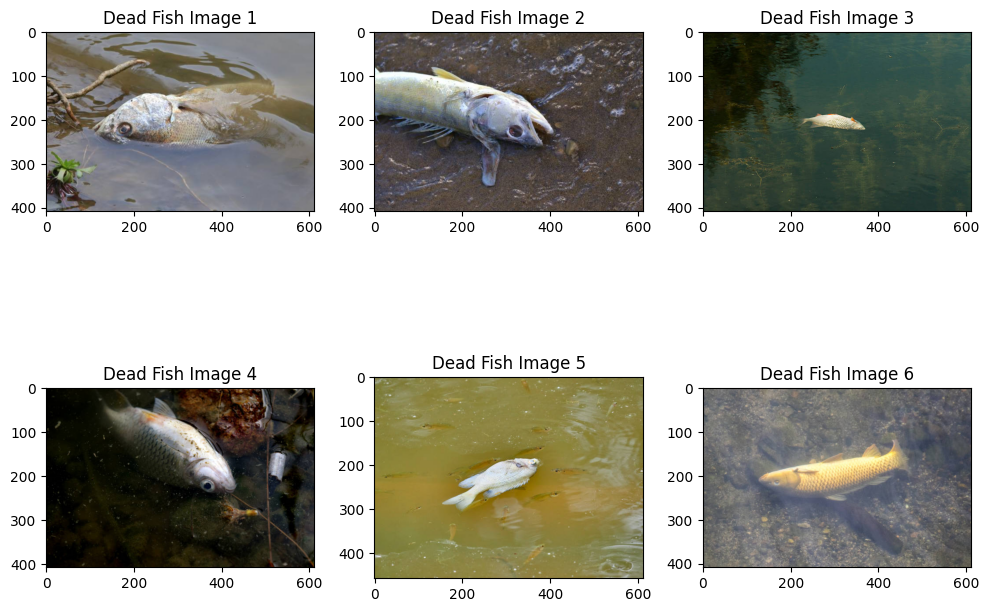

In [20]:
dir_1 = "/content/drive/MyDrive/Fish/Dead"
dir_1 = pathlib.Path(dir_1)
image_files = list(dir_1.rglob("*.jpg")) + list(dir_1.rglob("*.png")) + list(dir_1.rglob("*.jpeg"))
print(len(image_files))


import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for i, img_path in enumerate(image_files[:6]):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+1)   # 2 rows, 3 columns
    plt.imshow(img)
    plt.title(f'Dead Fish Image {i+1}')

plt.tight_layout()
plt.show()


53


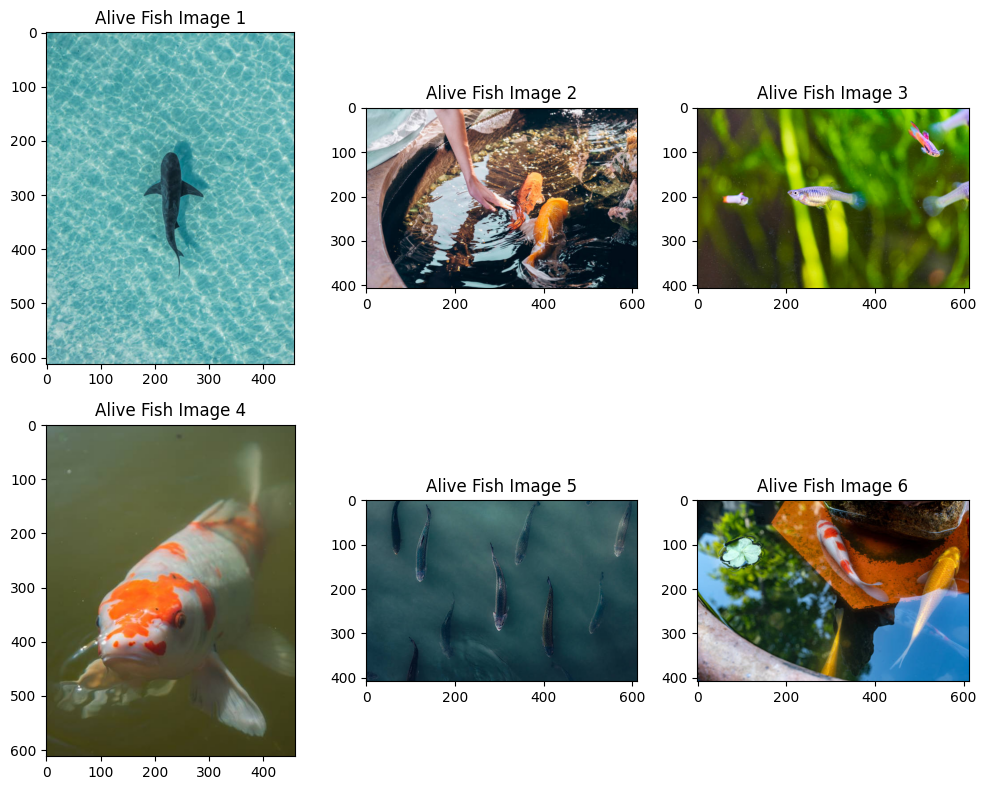

In [22]:
dir_2 = "/content/drive/MyDrive/Fish/Alive"
dir_2 = pathlib.Path(dir_2)
image_files = list(dir_2.rglob("*.jpg")) + list(dir_2.rglob("*.png")) + list(dir_2.rglob("*.jpeg"))
print(len(image_files))
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
for i, image_path in enumerate(image_files[:6]):
  img = cv2.imread(str(image_path))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(2, 3, i+1)   # 2 rows, 3 columns
  plt.imshow(img)
  plt.title(f'Alive Fish Image {i+1}')

plt.tight_layout()
plt.show()



In [7]:
img_size=(224,224)
batch_size = 16
seed = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode = 'binary',
    validation_split = 0.2,
    subset = "training",
    seed = seed,
    image_size = img_size,
    batch_size = batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset="validation",
    seed =seed,
    image_size = img_size,
    batch_size = batch_size
)
class_names = train_ds.class_names
print(class_names)

Found 105 files belonging to 2 classes.
Using 84 files for training.
Found 105 files belonging to 2 classes.
Using 21 files for validation.
['Alive', 'Dead']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
])


In [10]:
from tensorflow.keras import Input

cnn_model = keras.Sequential([
    Input(shape=(224, 224, 3)),         # <<< Specify input shape here explicitly
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


cnn_model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_cnn_model.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4328 - loss: 1.1769

6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4305 - loss: 1.1741 - val_accuracy: 0.4762 - val_loss: 0.7015
Epoch 2/20
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5200 - loss: 0.6647

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.5415 - loss: 0.6644 - val_accuracy: 0.8095 - val_loss: 0.5886
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.6927 - loss: 0.5951 - val_accuracy: 0.6667 - val_loss: 0.5695
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6220 - loss: 0.6471 - val_accuracy: 0.5714 - val_loss: 0.6015
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7305 - loss: 0.5679 - val_accuracy: 0.7619 - val_loss: 0.5571
Epoch 6/20
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7185 - loss: 0.5381

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.7173 - loss: 0.5394 - val_accuracy: 0.8571 - val_loss: 0.4729
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.7864 - loss: 0.4870 - val_accuracy: 0.7143 - val_loss: 0.5071
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7266 - loss: 0.5155 - val_accuracy: 0.7143 - val_loss: 0.4238
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8307 - loss: 0.3923 - val_accuracy: 0.6667 - val_loss: 0.4851
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8195 - loss: 0.4247 - val_accuracy: 0.8571 - val_loss: 0.3480
Epoch 11/20
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9052 - loss: 0.3020

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.8949 - loss: 0.3055 - val_accuracy: 0.9048 - val_loss: 0.2568
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.7700 - loss: 0.3749 - val_accuracy: 0.7619 - val_loss: 0.3968
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.9097 - loss: 0.2796 - val_accuracy: 0.8571 - val_loss: 0.3814
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8923 - loss: 0.2729 - val_accuracy: 0.8095 - val_loss: 0.4666
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9186 - loss: 0.1966 - val_accuracy: 0.7143 - val_loss: 0.6026
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8885 - loss: 0.2258 - val_accuracy: 0.8095 - val_loss: 0.4385
Epoch 17/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9570 - loss: 0.1656 - val_accuracy: 0.7143 - val_loss: 0.7772
Epoch 18/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9369 - loss: 0.1601 - val_accuracy: 0.9048 - val_loss: 0.2

In [11]:
basemodel = keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
basemodel.trainable = False

# Freeze all except last N layers (e.g., last 20 layers)
for layer in basemodel.layers[:-20]:
    layer.trainable = False

model = keras.Sequential([
    layers.InputLayer(input_shape=(224,224,3)),
    data_augmentation,
    layers.Rescaling(1./255),
    basemodel,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

history_transfer_model=model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=20
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 819ms/step - accuracy: 0.4086 - loss: 0.7828 - val_accuracy: 0.5238 - val_loss: 0.7169
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5179 - loss: 0.7469 - val_accuracy: 0.5238 - val_loss: 0.7278
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.4319 - loss: 0.7698 - val_accuracy: 0.4762 - val_loss: 0.7026
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.4772 - loss: 0.7106 - val_accuracy: 0.4762 - val_loss: 0.6965
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.4918 - loss: 0.7041 - val_accuracy: 0.5238 - val_loss: 0.6935
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5015 - loss: 0.7058 - val_accuracy: 0.5238 - val_loss: 0.6944
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4327 - loss: 0.7302 - val_accuracy: 0.4762 - val_loss: 0.6941
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4547 - loss: 0.7128 - val_accuracy: 0.4762 - val_loss

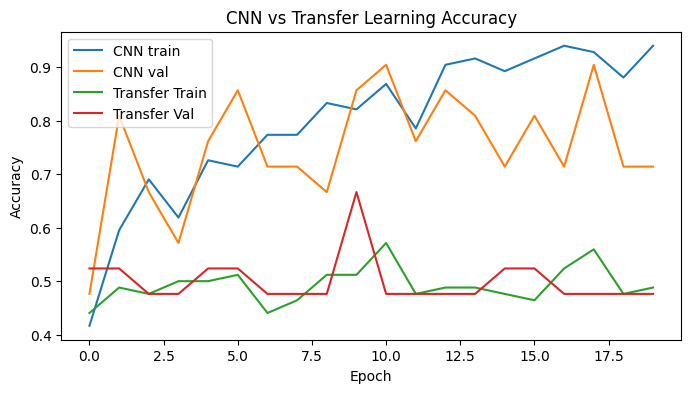

In [18]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='CNN train')
plt.plot(history.history['val_accuracy'], label='CNN val')
plt.plot(history_transfer_model.history['accuracy'], label='Transfer Train')
plt.plot(history_transfer_model.history['val_accuracy'], label='Transfer Val')

plt.title("CNN vs Transfer Learning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [13]:
history
history_transfer_model

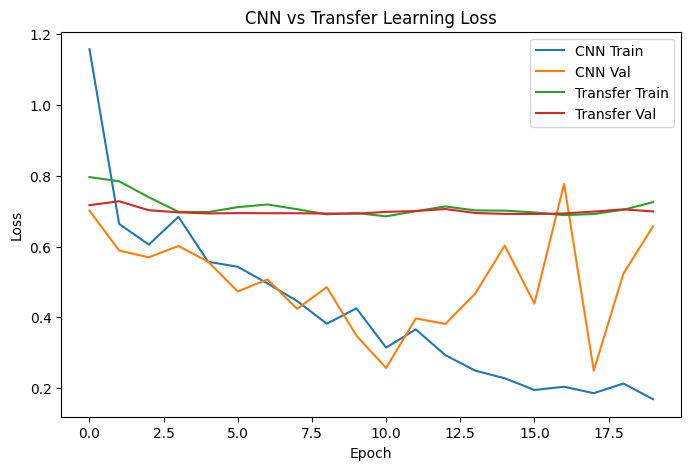

In [19]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='CNN Train')
plt.plot(history.history['val_loss'], label='CNN Val')

plt.plot(history_transfer_model.history['loss'], label='Transfer Train')
plt.plot(history_transfer_model.history['val_loss'], label='Transfer Val')

plt.title("CNN vs Transfer Learning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [59]:
import tensorflow as tf
import pathlib

data_dir = pathlib.Path("/content/drive/MyDrive/Fish")  # folder path
img_size = (224, 224)
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


Found 105 files belonging to 2 classes.
Using 84 files for training.
Found 105 files belonging to 2 classes.
Using 21 files for validation.


In [60]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

base_model.trainable = False  # freeze full model

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



In [61]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 321ms/step - accuracy: 0.3905 - loss: 0.7565 - val_accuracy: 0.6667 - val_loss: 0.6642
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7712 - loss: 0.5589 - val_accuracy: 0.7143 - val_loss: 0.6085
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8258 - loss: 0.4846 - val_accuracy: 0.7619 - val_loss: 0.5631
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8878 - loss: 0.4578 - val_accuracy: 0.7619 - val_loss: 0.5203
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9204 - loss: 0.3749 - val_accuracy: 0.7619 - val_loss: 0.4815
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9306 - loss: 0.3542 - val_accuracy: 0.8571 - val_loss: 0.4498
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9311 - loss: 0.3492 - val_accuracy: 0.8571 - val_loss: 0.4228
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9344 - loss: 0.2806 - val_accuracy: 0.8571

In [63]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(train_ds, val_ds, epochs=20)


ValueError: When providing `x` as a tf.data.Dataset, `y` should not be passed. Instead, the targets should be included as part of the tf.data.Dataset.

In [34]:
model.save("fish_alive_dead_model.keras")


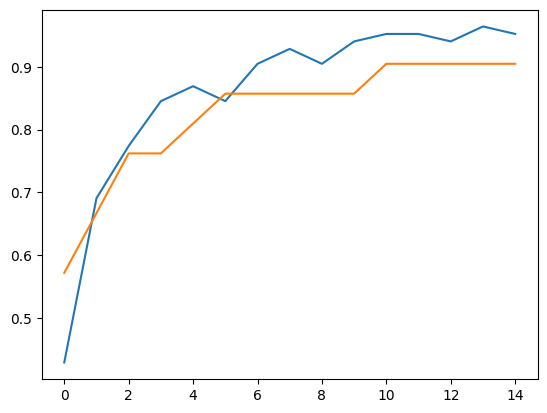

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [36]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/fish_alive_dead_model.keras")
print("Model loaded successfully!")


Model loaded successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [38]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_size = 224  # same size used during training

def predict_fish(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(img_size, img_size))

    # Convert to array
    img_array = image.img_to_array(img)

    # Expand dims → (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize
    img_array = img_array / 255.0

    # Predict
    pred = model.predict(img_array)[0][0]

    # Threshold 0.5 for binary classification
    if pred >= 0.5:
        print(f"Prediction: 🟢 ALIVE ({pred:.2f})")
    else:
        print(f"Prediction: 🔴 DEAD ({pred:.2f})")


In [53]:
from google.colab import files
imge = files.upload()

Saving Screenshot 2025-12-12 120717.png to Screenshot 2025-12-12 120717 (1).png
Saving Screenshot 2025-12-12 120728.png to Screenshot 2025-12-12 120728.png
Saving Screenshot 2025-12-12 120738.png to Screenshot 2025-12-12 120738 (1).png
Saving Screenshot 2025-12-12 122235.png to Screenshot 2025-12-12 122235 (1).png
Saving Screenshot 2025-12-12 122241.png to Screenshot 2025-12-12 122241 (1).png


In [55]:
predict_fish("Screenshot 2025-12-12 120717.png")
predict_fish("Screenshot 2025-12-12 120728.png")
predict_fish("Screenshot 2025-12-12 120738.png")
predict_fish("Screenshot 2025-12-12 122235.png")
predict_fish("Screenshot 2025-12-12 122241.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: 🔴 DEAD (0.31)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: 🔴 DEAD (0.31)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction: 🔴 DEAD (0.31)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction: 🔴 DEAD (0.31)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction: 🔴 DEAD (0.31)


In [58]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_size = 224  # same size used during training

def predict_fish(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(img_size, img_size))

    # Convert to array
    img_array = image.img_to_array(img)

    # Expand dims → (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize
    img_array = img_array / 255.0

    # Predict
    pred = model.predict(img_array)[0][0]

    # Threshold 0.5 for binary classification
    if pred >= 0.5:
        print(f"Prediction: 🟢 ALIVE ({pred:.2f})")
    else:
        print(f"Prediction: 🔴 DEAD ({pred:.2f})")


In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np



data_dir = "/content/drive/MyDrive/Fish"   # only alive & dead inside
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2   # 20% for validation
)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)


model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(train_data.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

model.save("fish_detector_model.keras")
print("Model saved successfully!")




Found 85 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.4450 - loss: 4.9077 - val_accuracy: 0.5000 - val_loss: 2.4684
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - accuracy: 0.4971 - loss: 1.9977 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.6203 - loss: 0.6567 - val_accuracy: 0.5000 - val_loss: 0.7373
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - accuracy: 0.5269 - loss: 0.7731 - val_accuracy: 0.5000 - val_loss: 0.6826
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.5857 - loss: 0.6756 - val_accuracy: 0.7000 - val_loss: 0.6764
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.7115 - loss: 0.6674 - val_accuracy: 0.4500 - val_loss: 0.6650
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.5460 - loss: 0.6500 - val_accuracy: 0.7500 - val_loss: 0.5946
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.7095 - loss: 0.5734 - val_accuracy: 0.7000 - val_loss: 0

Model loaded!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
Prediction: Dead  (0.75)


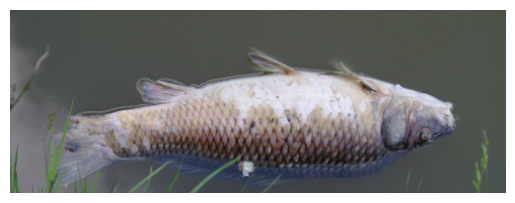

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Dead  (0.87)


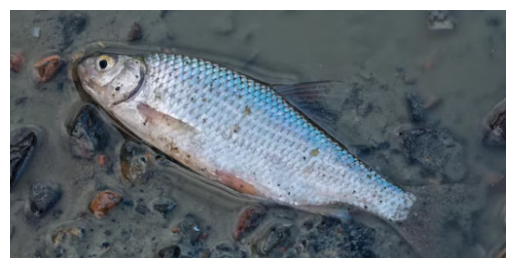

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Dead  (0.85)


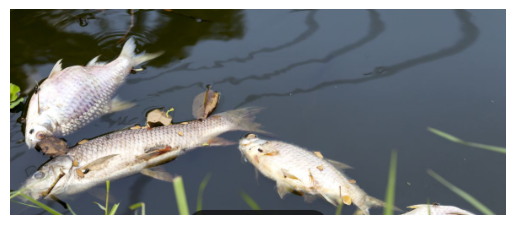

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: Alive  (0.97)


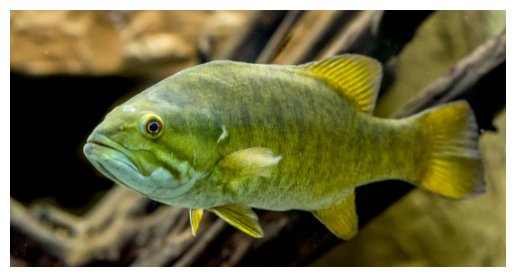

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: Alive  (0.97)


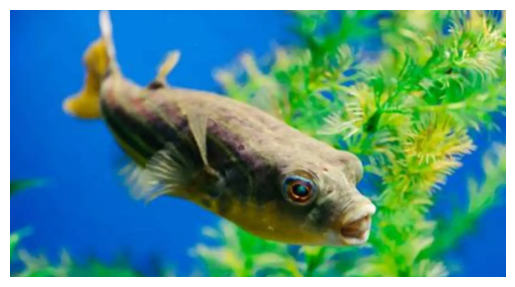

In [71]:
model = load_model("fish_detector_model.keras")
print("Model loaded!")

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_image(path):
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    idx = np.argmax(pred)

    labels = list(train_data.class_indices.keys())

    print(f"Prediction: {labels[idx]}  ({pred[0][idx]:.2f})")

    # Display image
    plt.imshow(load_img(path))
    plt.axis("off")
    plt.show()


# Example:
predict_image("Screenshot 2025-12-12 120717.png")
predict_image("Screenshot 2025-12-12 120728.png")
predict_image("Screenshot 2025-12-12 120738.png")
predict_image("Screenshot 2025-12-12 122235.png")
predict_image("Screenshot 2025-12-12 122241.png")
